In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
import pandas as pd
import numpy as np

path = "core_ETF.xlsx"
sheet = 0

meta = pd.read_excel(path, sheet_name=sheet, header=None, nrows=3)
tickers = meta.iloc[0].tolist()

def clean(x):
    if pd.isna(x):
        return ""
    return str(x).strip()

tickers = [clean(x) for x in tickers]

df = pd.read_excel(path, sheet_name=sheet, header=None, skiprows=3)

# 1) calendrier référence = 1ère colonne date
ref_raw = df.iloc[:, 0]
ref_num = pd.to_numeric(ref_raw, errors="coerce")
mask_excel = ref_num.between(20000, 60000)

ref_dates = ref_raw.copy()
ref_dates.loc[mask_excel] = pd.to_datetime(ref_num[mask_excel], unit="D", origin="1899-12-30")
ref_dates.loc[~mask_excel] = pd.to_datetime(ref_raw[~mask_excel], errors="coerce")

# garder seulement les lignes où la date est valide
valid = ref_dates.notna()
df = df.loc[valid].reset_index(drop=True)
ref_dates = pd.to_datetime(ref_dates.loc[valid]).reset_index(drop=True)

# 2) wide = index = ref_dates, colonnes = tickers, valeurs = colonnes "Price" uniquement
wide = pd.DataFrame(index=ref_dates)

for j in range(0, df.shape[1], 2):
    price_col = j + 1
    if price_col >= df.shape[1]:
        break

    # ticker associé à la colonne prix
    tkr = tickers[price_col] if price_col < len(tickers) and tickers[price_col] not in ("", "Date") else f"UNKNOWN_{j//2}"

    px = pd.to_numeric(df.iloc[:, price_col], errors="coerce").values
    wide[tkr] = px

wide = wide.sort_index()

# 3) Forcer les dates : combler trous intra-séries (si un ETF manque un jour)
wide = wide.ffill()

print(wide.head())
print("index min/max:", wide.index.min(), wide.index.max())
print("colonnes:", wide.shape[1])

            SWDA LN Equity  IWDA LN Equity  IWRD LN Equity  EUNL GR Equity  \
0                                                                            
2010-01-04       1632.5699           26.31          1591.0           18.17   
2010-01-05       1644.5100           26.30          1600.0           18.23   
2010-01-06       1646.7500           26.39          1604.0           18.26   
2010-01-07       1652.4399           26.30          1610.0           18.30   
2010-01-08       1652.6200           26.41          1610.0           18.39   

            CSUS LN Equity  IMEU LN Equity  CSJP LN Equity  SPXJ LN Equity  \
0                                                                            
2010-01-04           94.56       1477.3299          5823.0       2467.5300   
2010-01-05           94.50       1482.5300          5782.0       2487.8799   
2010-01-06           94.94       1483.4399          5770.0       2496.0701   
2010-01-07           96.16       1483.5401          5842.0     

In [11]:
# --- Buckets (ligne 1)
buckets = meta.iloc[1].tolist()
buckets = [clean(x) for x in buckets]

# mapping ticker -> bucket (en utilisant les mêmes price_col que pour wide)
ticker_to_bucket = {}
for j in range(0, df.shape[1], 2):
    price_col = j + 1
    if price_col >= df.shape[1]:
        break
    tkr = tickers[price_col] if price_col < len(tickers) and tickers[price_col] not in ("", "Date") else f"UNKNOWN_{j//2}"
    bkt = buckets[price_col] if price_col < len(buckets) else ""
    ticker_to_bucket[tkr] = bkt

In [12]:
themes = {
    "Equity": {"Equity DM (Core)", "Equity DM (Regional)"},
    "Rates": {"Rates EMU Govies (Core)", "Rates EMU Govies (Bucket)", "Rates EMU Govies (Linkers)"},
    "Credit": {"Credit EMU IG (Core)", "Credit EMU IG (Bucket)", "Credit EMU IG (Large Cap)",
               "Credit EMU IG (Covered)", "EMU Aggregate (IG)"},
}

In [13]:
rets = np.log(wide).diff()

def candidates_for(theme_name):
    return [t for t in wide.columns if ticker_to_bucket.get(t, "") in themes[theme_name]]

def pick_best(theme_name, min_obs=750):
    cands = candidates_for(theme_name)
    # garder ceux avec assez d'historique
    cands = [t for t in cands if rets[t].dropna().shape[0] >= min_obs]
    if len(cands) == 0:
        raise ValueError(f"Aucun candidat pour {theme_name} avec min_obs={min_obs}")

    R = rets[cands].dropna(how="all")
    corr = R.corr()
    mean_corr = corr.mean(axis=1)          # représentativité
    nobs = R.notna().sum()                 # longueur d'historique
    vol = R.std()                          # pour éviter les trucs trop extrêmes

    score = mean_corr + 0.0001*nobs - 0.1*vol
    best = score.sort_values(ascending=False).index[0]
    return best, score.sort_values(ascending=False)

best_eq, rank_eq = pick_best("Equity")
best_rt, rank_rt = pick_best("Rates")
best_cr, rank_cr = pick_best("Credit")

print("Best Equity:", best_eq, "| bucket:", ticker_to_bucket[best_eq])
print("Best Rates :", best_rt, "| bucket:", ticker_to_bucket[best_rt])
print("Best Credit:", best_cr, "| bucket:", ticker_to_bucket[best_cr])

Best Equity: SWDA LN Equity | bucket: Equity DM (Core)
Best Rates : CBE3 LN Equity | bucket: Rates EMU Govies (Bucket)
Best Credit: IEAC LN Equity | bucket: Credit EMU IG (Core)


In [14]:
core3 = [best_eq, best_rt, best_cr]
R = rets[core3].dropna()

mu = R.mean() * 252
cov = R.cov() * 252

# grid long-only: w1,w2,w3 >=0, sum=1
grid = np.linspace(0, 1, 201)
ports = []
for w1 in grid:
    for w2 in grid:
        w3 = 1 - w1 - w2
        if w3 < 0:
            continue
        w = np.array([w1, w2, w3])
        ret = float(w @ mu.values)
        vol = float(np.sqrt(w @ cov.values @ w))
        ports.append((ret, vol, w))

ports = np.array(ports, dtype=object)

# min variance
minv = min(ports, key=lambda x: x[1])
# max Sharpe (rf=0 par défaut, tu peux mettre un rf annuel)
rf = 0.0
maxs = max(ports, key=lambda x: (x[0]-rf)/x[1] if x[1]>0 else -np.inf)

print("\n--- Core (3 ETFs) ---")
print("Tickers:", core3)
print("\nMin-Variance:")
print("Return:", minv[0], "Vol:", minv[1], "Weights:", minv[2])
print("\nMax-Sharpe:")
print("Return:", maxs[0], "Vol:", maxs[1], "Weights:", maxs[2])


--- Core (3 ETFs) ---
Tickers: ['SWDA LN Equity', 'CBE3 LN Equity', 'IEAC LN Equity']

Min-Variance:
Return: 0.008110448166774937 Vol: 0.014105566703104736 Weights: [0.005 0.885 0.11 ]

Max-Sharpe:
Return: 0.02093468648811262 Vol: 0.022603534634437587 Weights: [0.125 0.875 0.   ]


# 🔍 Audit de la sélection des ETFs Core

Vérifions la qualité de la sélection : critères qualitatifs (bucket, représentativité) et quantitatifs (Sharpe, corrélation moyenne, profondeur d'historique).

In [18]:
# --- Vérification qualitative et quantitative de la sélection ---
print("=" * 70)
print("AUDIT DE LA SÉLECTION DES ETFs CORE")
print("=" * 70)

for theme in ["Equity", "Rates", "Credit"]:
    cands = candidates_for(theme)
    cands_filtered = [t for t in cands if rets[t].dropna().shape[0] >= 750]
    print(f"\n{'─'*50}")
    print(f"Thème : {theme}")
    print(f"Candidats bruts : {len(cands)} | après filtre min_obs=750 : {len(cands_filtered)}")
    
    if len(cands_filtered) == 0:
        continue
    
    R_theme = rets[cands_filtered].dropna(how="all")
    corr = R_theme.corr()
    mean_corr = corr.mean(axis=1)
    nobs = R_theme.notna().sum()
    vol_daily = R_theme.std()
    ann_ret = R_theme.mean() * 252
    ann_vol = vol_daily * np.sqrt(252)
    sharpe = ann_ret / ann_vol
    
    summary = pd.DataFrame({
        "Bucket": [ticker_to_bucket.get(t, "") for t in cands_filtered],
        "Ann.Ret%": (ann_ret * 100).round(2),
        "Ann.Vol%": (ann_vol * 100).round(2),
        "Sharpe": sharpe.round(3),
        "MeanCorr": mean_corr.round(3),
        "Nobs": nobs,
        "Score": (mean_corr + 0.0001*nobs - 0.1*vol_daily).round(4)
    }, index=cands_filtered).sort_values("Score", ascending=False)
    
    print(summary.to_string())
    print(f"\n  → Sélectionné : {summary.index[0]}")
    
    # Vérification critique : le meilleur en Score est-il aussi bon en Sharpe ?
    best_score_ticker = summary.index[0]
    best_sharpe_ticker = summary["Sharpe"].idxmax()
    if best_score_ticker != best_sharpe_ticker:
        print(f"  ⚠️  Attention : meilleur Score ≠ meilleur Sharpe ({best_sharpe_ticker}, Sharpe={summary.loc[best_sharpe_ticker, 'Sharpe']:.3f})")
    else:
        print(f"  ✅ Cohérent : meilleur Score = meilleur Sharpe")

AUDIT DE LA SÉLECTION DES ETFs CORE

──────────────────────────────────────────────────
Thème : Equity
Candidats bruts : 8 | après filtre min_obs=750 : 8
                              Bucket  Ann.Ret%  Ann.Vol%  Sharpe  MeanCorr  Nobs   Score
SWDA LN Equity      Equity DM (Core)     11.14     14.74   0.756     0.563  4040  0.9661
IWRD LN Equity      Equity DM (Core)      9.28     14.83   0.625     0.562  4040  0.9653
IMEU LN Equity  Equity DM (Regional)      4.83     16.20   0.298     0.541  4040  0.9439
IWDA LN Equity      Equity DM (Core)     10.02     16.20   0.618     0.529  4040  0.9324
SPXJ LN Equity  Equity DM (Regional)      2.73     17.41   0.157     0.517  4040  0.9203
CSJP LN Equity  Equity DM (Regional)      7.20     16.41   0.439     0.148  4040  0.5514
EUNL GR Equity      Equity DM (Core)     11.23     16.67   0.674     0.143  4040  0.5458
CSUS LN Equity  Equity DM (Regional)     12.58     15.60   0.807     0.132  4040  0.5350

  → Sélectionné : SWDA LN Equity
  ⚠️  Atten

# 📈 Frontière Efficiente — 3 ETFs Core

Tracé de la frontière efficiente Markowitz (long-only) avec les portefeuilles remarquables :
- **Min-Variance** (risque minimal)
- **Max-Sharpe** (meilleur rendement/risque)
- **Equal-Weight** (1/3 chacun, benchmark naïf)

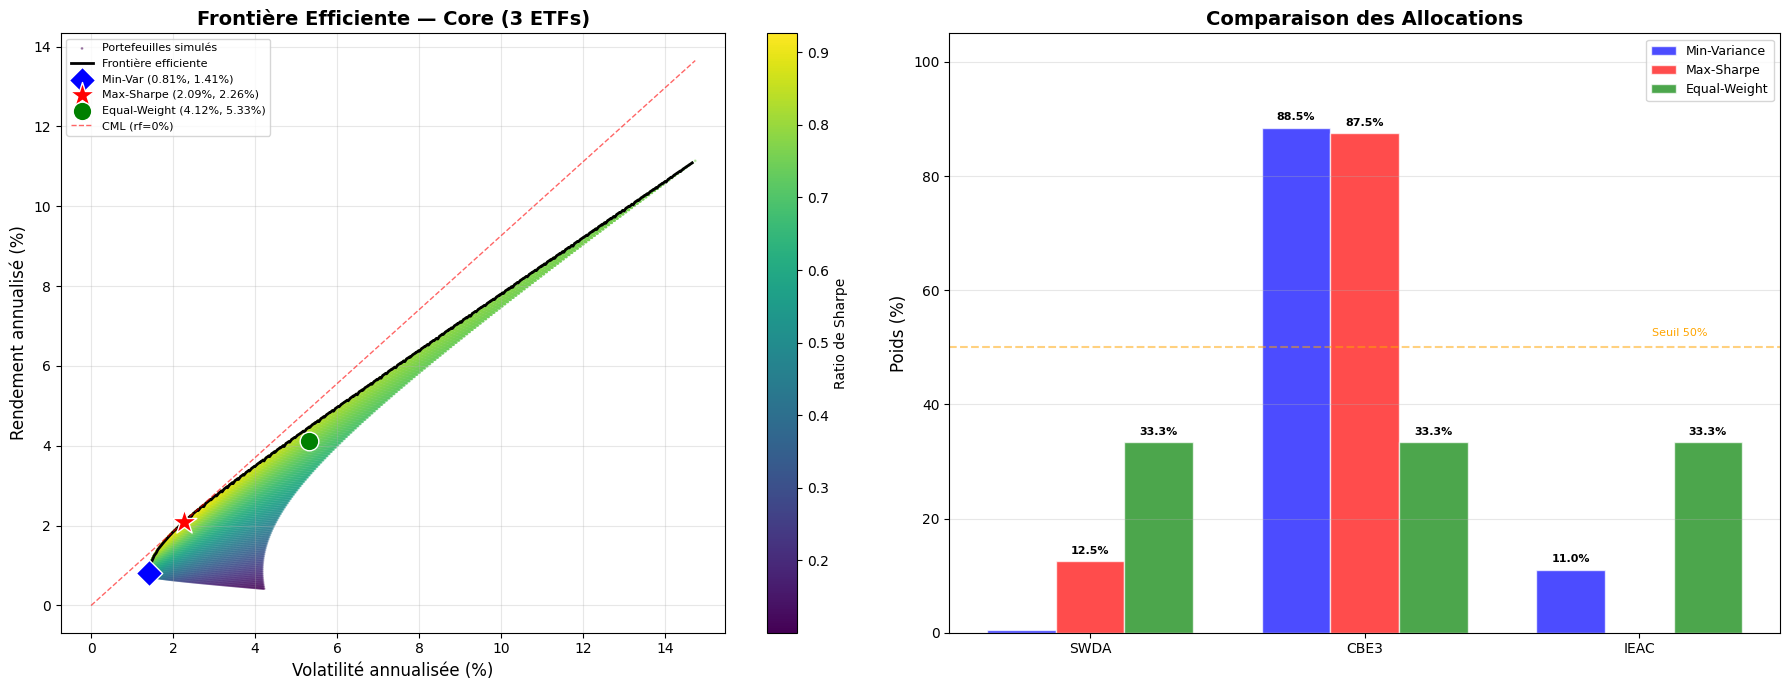


RÉSUMÉ DES ALLOCATIONS

Min-Variance:
  Poids    : {'SWDA': '0.5%', 'CBE3': '88.5%', 'IEAC': '11.0%'}
  Return   : 0.81%  |  Vol : 1.41%  |  Sharpe : 0.575
  HHI      : 0.795  ⚠️ CONCENTRÉ

Max-Sharpe:
  Poids    : {'SWDA': '12.5%', 'CBE3': '87.5%', 'IEAC': '0.0%'}
  Return   : 2.09%  |  Vol : 2.26%  |  Sharpe : 0.926
  HHI      : 0.781  ⚠️ CONCENTRÉ

Equal-Weight:
  Poids    : {'SWDA': '33.3%', 'CBE3': '33.3%', 'IEAC': '33.3%'}
  Return   : 4.12%  |  Vol : 5.33%  |  Sharpe : 0.774
  HHI      : 0.333  ✅ Diversifié


In [19]:
# ─── Frontière efficiente calibrée ───
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Données du nuage ---
vols_all = np.array([p[1] for p in ports], dtype=float)
rets_all = np.array([p[0] for p in ports], dtype=float)
sharpe_all = np.where(vols_all > 0, (rets_all - rf) / vols_all, -np.inf)

# --- Frontière efficiente (enveloppe supérieure) ---
n_bins = 300
vol_bins = np.linspace(vols_all.min(), vols_all.max(), n_bins)
frontier_ret = []
frontier_vol = []
for i in range(len(vol_bins) - 1):
    mask = (vols_all >= vol_bins[i]) & (vols_all < vol_bins[i+1])
    if mask.sum() > 0:
        best_idx = np.argmax(rets_all[mask])
        idx_global = np.where(mask)[0][best_idx]
        frontier_vol.append(vols_all[idx_global])
        frontier_ret.append(rets_all[idx_global])

frontier_vol = np.array(frontier_vol)
frontier_ret = np.array(frontier_ret)

# --- Portefeuilles remarquables ---
w_eq = np.array([1/3, 1/3, 1/3])
ret_eq = float(w_eq @ mu.values)
vol_eq = float(np.sqrt(w_eq @ cov.values @ w_eq))

# ──────────────────────────────────────────────
#  AXE 1 : Frontière efficiente
# ──────────────────────────────────────────────
ax = axes[0]
ax.scatter(vols_all * 100, rets_all * 100, c=sharpe_all, cmap="viridis",
           s=1, alpha=0.4, label="Portefeuilles simulés")
ax.plot(frontier_vol * 100, frontier_ret * 100, 'k-', lw=2, label="Frontière efficiente")

# Portefeuilles remarquables
ax.scatter(minv[1]*100, minv[0]*100, marker='D', s=180, c='blue', 
           edgecolors='white', zorder=5, label=f"Min-Var ({minv[0]*100:.2f}%, {minv[1]*100:.2f}%)")
ax.scatter(maxs[1]*100, maxs[0]*100, marker='*', s=350, c='red', 
           edgecolors='white', zorder=5, label=f"Max-Sharpe ({maxs[0]*100:.2f}%, {maxs[1]*100:.2f}%)")
ax.scatter(vol_eq*100, ret_eq*100, marker='o', s=180, c='green', 
           edgecolors='white', zorder=5, label=f"Equal-Weight ({ret_eq*100:.2f}%, {vol_eq*100:.2f}%)")

# Capital Market Line
vol_range = np.linspace(0, vols_all.max() * 100, 100)
cml_ret = rf * 100 + (maxs[0] - rf) / maxs[1] * vol_range
ax.plot(vol_range, cml_ret, 'r--', lw=1, alpha=0.6, label="CML (rf=0%)")

ax.set_xlabel("Volatilité annualisée (%)", fontsize=12)
ax.set_ylabel("Rendement annualisé (%)", fontsize=12)
ax.set_title("Frontière Efficiente — Core (3 ETFs)", fontsize=14, fontweight='bold')
ax.legend(fontsize=8, loc='upper left')
ax.grid(True, alpha=0.3)

# colorbar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=sharpe_all[sharpe_all > -np.inf].min(), vmax=sharpe_all.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Ratio de Sharpe", fontsize=10)

# ──────────────────────────────────────────────
#  AXE 2 : Poids des portefeuilles remarquables
# ──────────────────────────────────────────────
ax2 = axes[1]
labels = ["Min-Variance", "Max-Sharpe", "Equal-Weight"]
weights_list = [minv[2], maxs[2], w_eq]
x = np.arange(len(core3))
width = 0.25
colors = ['blue', 'red', 'green']

for i, (lbl, w, c) in enumerate(zip(labels, weights_list, colors)):
    bars = ax2.bar(x + i*width, w*100, width, label=lbl, color=c, alpha=0.7, edgecolor='white')
    for bar, val in zip(bars, w*100):
        if val > 2:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                     f"{val:.1f}%", ha='center', va='bottom', fontsize=8, fontweight='bold')

ax2.set_xticks(x + width)
ax2.set_xticklabels([t.split()[0] for t in core3], fontsize=10)
ax2.set_ylabel("Poids (%)", fontsize=12)
ax2.set_title("Comparaison des Allocations", fontsize=14, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 105)

# ── Annotation concentration ──
max_w_minv = max(minv[2]) * 100
max_w_maxs = max(maxs[2]) * 100
ax2.axhline(y=50, color='orange', linestyle='--', alpha=0.5)
ax2.text(2.5, 52, "Seuil 50%", color='orange', fontsize=8, ha='right')

plt.tight_layout()
plt.show()

# ── Résumé numérique ──
print("\n" + "=" * 60)
print("RÉSUMÉ DES ALLOCATIONS")
print("=" * 60)
for lbl, w in zip(labels, weights_list):
    ret_p = float(w @ mu.values) * 100
    vol_p = float(np.sqrt(w @ cov.values @ w)) * 100
    sr = ret_p / vol_p if vol_p > 0 else 0
    hhi = np.sum(w**2)  # indice de concentration Herfindahl
    print(f"\n{lbl}:")
    print(f"  Poids    : {dict(zip([t.split()[0] for t in core3], [f'{x:.1%}' for x in w]))}")
    print(f"  Return   : {ret_p:.2f}%  |  Vol : {vol_p:.2f}%  |  Sharpe : {sr:.3f}")
    print(f"  HHI      : {hhi:.3f}  {'⚠️ CONCENTRÉ' if hhi > 0.5 else '✅ Diversifié'}")


# ⚖️ Solutions Alternatives à la Surpondération

Le Markowitz classique concentre ~88% sur les Rates (CBE3) car c'est l'actif le moins volatile. On propose **4 approches alternatives** :

1. **Risk Parity** — chaque actif contribue autant au risque total
2. **Max Diversification** — maximise le ratio diversification
3. **Markowitz contraint** — Max-Sharpe avec plafond de poids (ex. 50%)
4. **Inverse Volatility** — poids proportionnels à 1/vol (simple, robuste)

In [20]:
from scipy.optimize import minimize

# ═══════════════════════════════════════════════════════════
#  1. RISK PARITY — Equal Risk Contribution (ERC)
# ═══════════════════════════════════════════════════════════
def risk_parity(cov_matrix):
    """Trouve les poids tels que chaque actif contribue autant au risque total."""
    n = cov_matrix.shape[0]
    Sigma = cov_matrix.values if hasattr(cov_matrix, 'values') else cov_matrix

    def risk_contribution(w):
        port_vol = np.sqrt(w @ Sigma @ w)
        mrc = Sigma @ w / port_vol          # marginal risk contribution
        rc = w * mrc                          # risk contribution
        target = port_vol / n                 # equal target
        return np.sum((rc - target) ** 2)

    w0 = np.ones(n) / n
    bounds = [(0.01, 1.0)] * n
    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    res = minimize(risk_contribution, w0, method="SLSQP", bounds=bounds, constraints=cons)
    return res.x

w_rp = risk_parity(cov)
print("1. RISK PARITY")
print(f"   Poids : {dict(zip([t.split()[0] for t in core3], [f'{x:.1%}' for x in w_rp]))}")

# ═══════════════════════════════════════════════════════════
#  2. MAXIMUM DIVERSIFICATION
# ═══════════════════════════════════════════════════════════
def max_diversification(cov_matrix):
    """Maximise le Diversification Ratio = (w'σ) / σ_p."""
    n = cov_matrix.shape[0]
    Sigma = cov_matrix.values if hasattr(cov_matrix, 'values') else cov_matrix
    vols = np.sqrt(np.diag(Sigma))

    def neg_div_ratio(w):
        port_vol = np.sqrt(w @ Sigma @ w)
        return -(w @ vols) / port_vol

    w0 = np.ones(n) / n
    bounds = [(0.01, 1.0)] * n
    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    res = minimize(neg_div_ratio, w0, method="SLSQP", bounds=bounds, constraints=cons)
    return res.x

w_md = max_diversification(cov)
print("\n2. MAX DIVERSIFICATION")
print(f"   Poids : {dict(zip([t.split()[0] for t in core3], [f'{x:.1%}' for x in w_md]))}")

# ═══════════════════════════════════════════════════════════
#  3. MARKOWITZ CONTRAINT (Max-Sharpe avec plafond 50%)
# ═══════════════════════════════════════════════════════════
def max_sharpe_constrained(mu_vec, cov_matrix, rf=0.0, max_weight=0.50):
    """Max Sharpe avec plafond de poids par actif."""
    n = len(mu_vec)
    Sigma = cov_matrix.values if hasattr(cov_matrix, 'values') else cov_matrix
    mu_arr = mu_vec.values if hasattr(mu_vec, 'values') else mu_vec

    def neg_sharpe(w):
        ret = w @ mu_arr
        vol = np.sqrt(w @ Sigma @ w)
        return -(ret - rf) / vol if vol > 1e-10 else 1e10

    w0 = np.ones(n) / n
    bounds = [(0.05, max_weight)] * n
    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    res = minimize(neg_sharpe, w0, method="SLSQP", bounds=bounds, constraints=cons)
    return res.x

w_cstr = max_sharpe_constrained(mu, cov, rf=rf, max_weight=0.50)
print("\n3. MARKOWITZ CONTRAINT (plafond 50%)")
print(f"   Poids : {dict(zip([t.split()[0] for t in core3], [f'{x:.1%}' for x in w_cstr]))}")

# ═══════════════════════════════════════════════════════════
#  4. INVERSE VOLATILITY
# ═══════════════════════════════════════════════════════════
ann_vols = np.sqrt(np.diag(cov.values))
w_iv = (1 / ann_vols) / (1 / ann_vols).sum()
print("\n4. INVERSE VOLATILITY")
print(f"   Poids : {dict(zip([t.split()[0] for t in core3], [f'{x:.1%}' for x in w_iv]))}")


1. RISK PARITY
   Poids : {'SWDA': '11.2%', 'CBE3': '42.8%', 'IEAC': '46.1%'}

2. MAX DIVERSIFICATION
   Poids : {'SWDA': '6.4%', 'CBE3': '71.5%', 'IEAC': '22.1%'}

3. MARKOWITZ CONTRAINT (plafond 50%)
   Poids : {'SWDA': '31.4%', 'CBE3': '50.0%', 'IEAC': '18.6%'}

4. INVERSE VOLATILITY
   Poids : {'SWDA': '7.0%', 'CBE3': '68.7%', 'IEAC': '24.4%'}


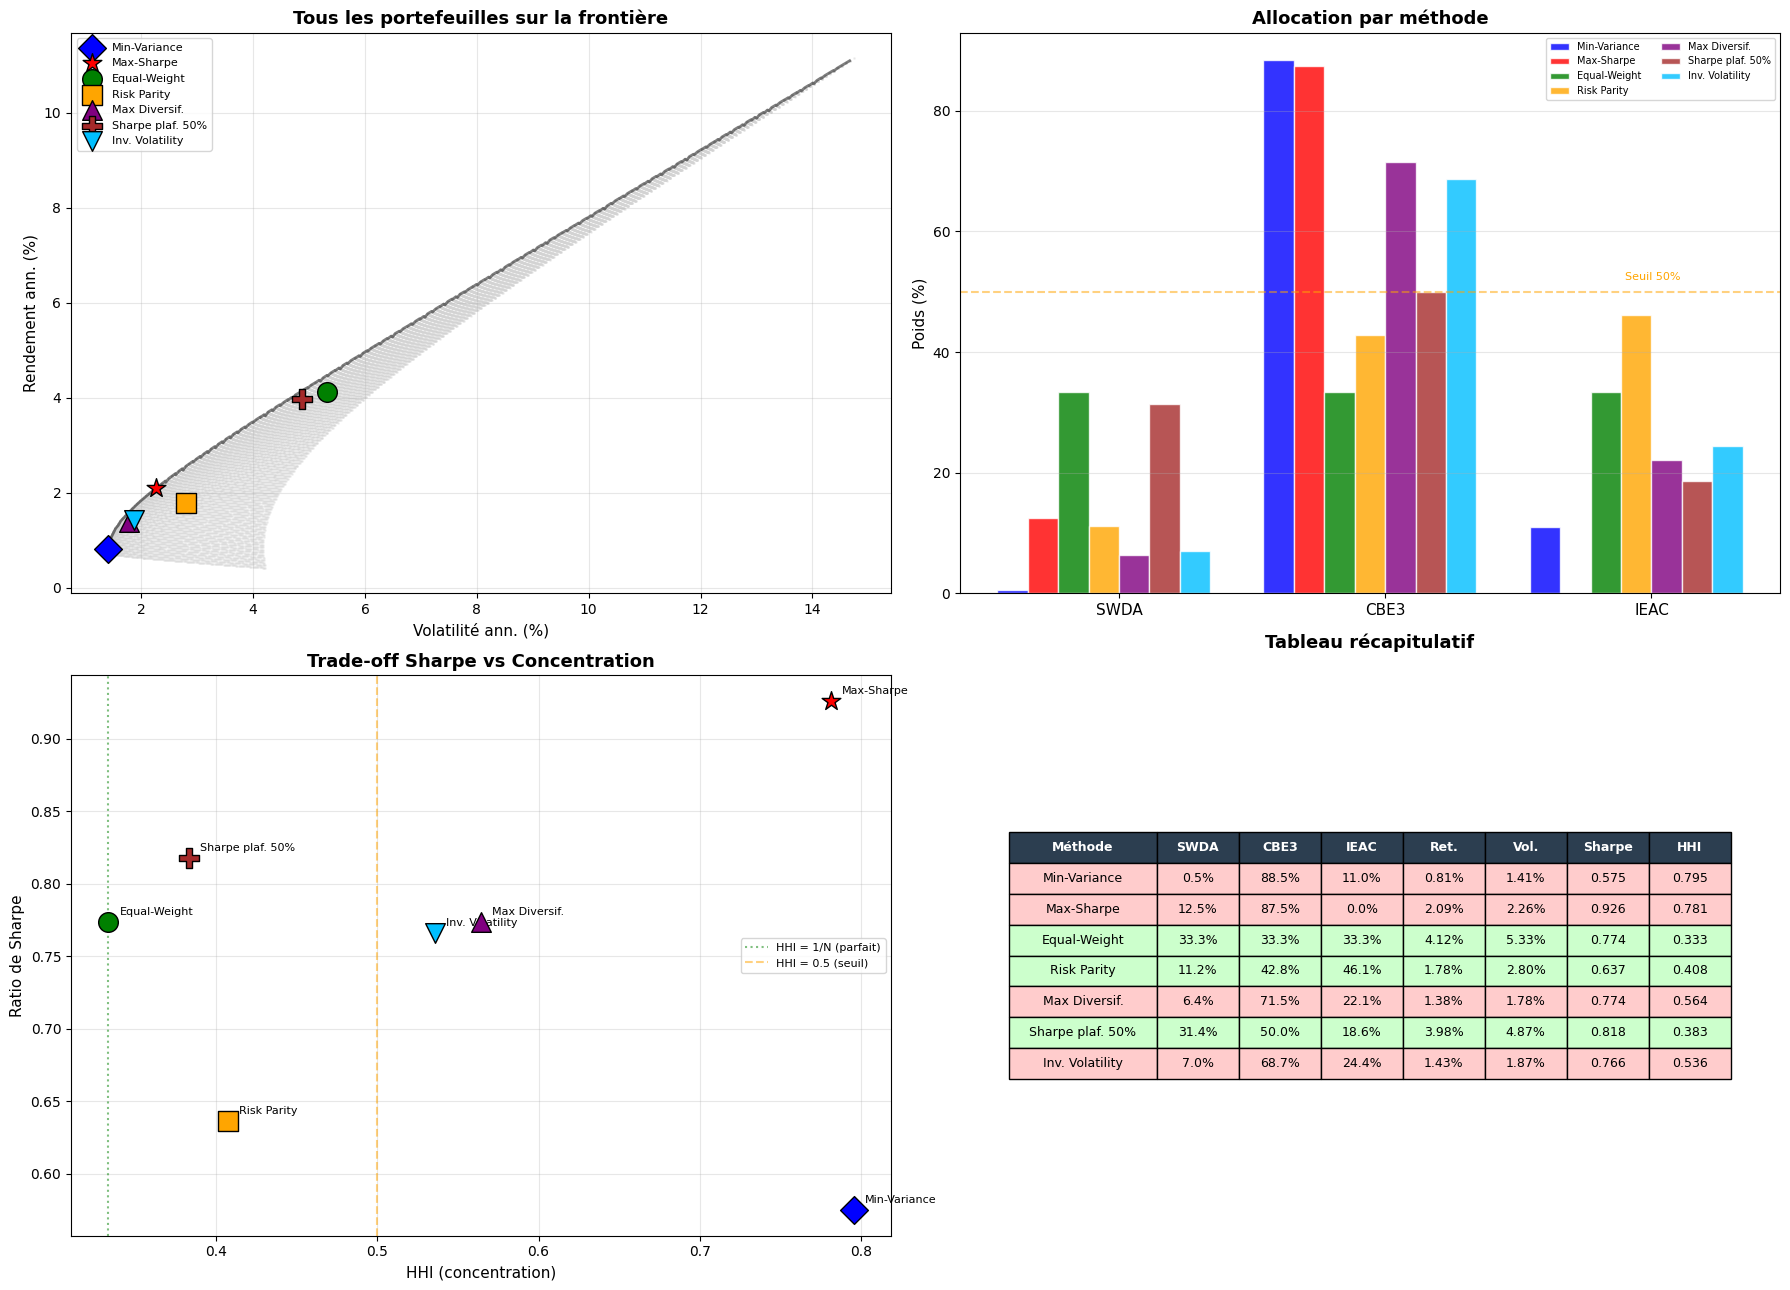


RECOMMANDATION

→ Meilleure méthode diversifiée (HHI < 0.5) : Sharpe plaf. 50%
  Poids : SWDA 31.4% | CBE3 50.0% | IEAC 18.6%
  Return 3.98% | Vol 4.87% | Sharpe 0.818 | HHI 0.383


In [21]:
# ═══════════════════════════════════════════════════════════
#  COMPARAISON COMPLÈTE DE TOUTES LES MÉTHODES
# ═══════════════════════════════════════════════════════════
all_methods = {
    "Min-Variance":       minv[2],
    "Max-Sharpe":         maxs[2],
    "Equal-Weight":       np.array([1/3, 1/3, 1/3]),
    "Risk Parity":        w_rp,
    "Max Diversif.":      w_md,
    "Sharpe plaf. 50%":   w_cstr,
    "Inv. Volatility":    w_iv,
}

# ── Calculer métriques pour chaque méthode ──
results = []
for name, w in all_methods.items():
    ret_p = float(w @ mu.values)
    vol_p = float(np.sqrt(w @ cov.values @ w))
    sr = (ret_p - rf) / vol_p if vol_p > 0 else 0
    hhi = float(np.sum(w**2))
    max_w = float(np.max(w))
    results.append({
        "Méthode": name,
        "Return%": ret_p * 100,
        "Vol%": vol_p * 100,
        "Sharpe": sr,
        "HHI": hhi,
        "MaxPoids%": max_w * 100,
        "w_Eq": w[0], "w_Rt": w[1], "w_Cr": w[2]
    })

df_res = pd.DataFrame(results).set_index("Méthode")

# ──────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(18, 13))

# ─── AXE 1 : Toutes les méthodes sur la frontière ───
ax = axes[0, 0]
ax.scatter(vols_all * 100, rets_all * 100, c='lightgray', s=1, alpha=0.3)
ax.plot(frontier_vol * 100, frontier_ret * 100, 'k-', lw=2, alpha=0.5)

markers = ['D', '*', 'o', 's', '^', 'P', 'v']
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'deepskyblue']
for (name, w), mk, c in zip(all_methods.items(), markers, colors):
    ret_p = float(w @ mu.values) * 100
    vol_p = float(np.sqrt(w @ cov.values @ w)) * 100
    ax.scatter(vol_p, ret_p, marker=mk, s=200, c=c, edgecolors='black',
               zorder=5, label=f"{name}")

ax.set_xlabel("Volatilité ann. (%)", fontsize=11)
ax.set_ylabel("Rendement ann. (%)", fontsize=11)
ax.set_title("Tous les portefeuilles sur la frontière", fontsize=13, fontweight='bold')
ax.legend(fontsize=8, loc='upper left')
ax.grid(True, alpha=0.3)

# ─── AXE 2 : Barplot des poids ───
ax2 = axes[0, 1]
x = np.arange(len(core3))
n_methods = len(all_methods)
width = 0.8 / n_methods

for i, ((name, w), c) in enumerate(zip(all_methods.items(), colors)):
    ax2.bar(x + i*width, w*100, width, label=name, color=c, alpha=0.8, edgecolor='white')

ax2.set_xticks(x + width * n_methods / 2)
ax2.set_xticklabels([t.split()[0] for t in core3], fontsize=11)
ax2.set_ylabel("Poids (%)", fontsize=11)
ax2.set_title("Allocation par méthode", fontsize=13, fontweight='bold')
ax2.axhline(50, color='orange', ls='--', alpha=0.5)
ax2.text(2.3, 52, "Seuil 50%", color='orange', fontsize=8)
ax2.legend(fontsize=7, ncol=2)
ax2.grid(True, alpha=0.3, axis='y')

# ─── AXE 3 : Sharpe vs HHI (trade-off) ───
ax3 = axes[1, 0]
for (name, _), c, mk in zip(all_methods.items(), colors, markers):
    row = df_res.loc[name]
    ax3.scatter(row["HHI"], row["Sharpe"], marker=mk, s=200, c=c,
                edgecolors='black', zorder=5)
    ax3.annotate(name, (row["HHI"], row["Sharpe"]),
                 textcoords="offset points", xytext=(8, 5), fontsize=8)

ax3.axvline(1/3, color='green', ls=':', alpha=0.5, label="HHI = 1/N (parfait)")
ax3.axvline(0.5, color='orange', ls='--', alpha=0.5, label="HHI = 0.5 (seuil)")
ax3.set_xlabel("HHI (concentration)", fontsize=11)
ax3.set_ylabel("Ratio de Sharpe", fontsize=11)
ax3.set_title("Trade-off Sharpe vs Concentration", fontsize=13, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# ─── AXE 4 : Tableau récapitulatif ───
ax4 = axes[1, 1]
ax4.axis('off')
table_data = []
for name in all_methods:
    r = df_res.loc[name]
    table_data.append([
        name,
        f"{r['w_Eq']*100:.1f}%",
        f"{r['w_Rt']*100:.1f}%",
        f"{r['w_Cr']*100:.1f}%",
        f"{r['Return%']:.2f}%",
        f"{r['Vol%']:.2f}%",
        f"{r['Sharpe']:.3f}",
        f"{r['HHI']:.3f}",
    ])

col_labels = ["Méthode", "SWDA", "CBE3", "IEAC", "Ret.", "Vol.", "Sharpe", "HHI"]
table = ax4.table(cellText=table_data, colLabels=col_labels, loc='center',
                  cellLoc='center', colWidths=[0.18, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# colorer les en-têtes
for j in range(len(col_labels)):
    table[0, j].set_facecolor('#2c3e50')
    table[0, j].set_text_props(color='white', fontweight='bold')

# colorer les lignes selon HHI
for i, name in enumerate(all_methods):
    hhi_val = df_res.loc[name, "HHI"]
    bg = '#ffcccc' if hhi_val > 0.5 else '#ccffcc'
    for j in range(len(col_labels)):
        table[i+1, j].set_facecolor(bg)

ax4.set_title("Tableau récapitulatif", fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# ─── Recommandation ───
print("\n" + "=" * 70)
print("RECOMMANDATION")
print("=" * 70)
# Filtrer les méthodes avec HHI < 0.5
diversified = df_res[df_res["HHI"] < 0.5].copy()
if len(diversified) > 0:
    best_div = diversified["Sharpe"].idxmax()
    print(f"\n→ Meilleure méthode diversifiée (HHI < 0.5) : {best_div}")
    r = df_res.loc[best_div]
    print(f"  Poids : SWDA {r['w_Eq']*100:.1f}% | CBE3 {r['w_Rt']*100:.1f}% | IEAC {r['w_Cr']*100:.1f}%")
    print(f"  Return {r['Return%']:.2f}% | Vol {r['Vol%']:.2f}% | Sharpe {r['Sharpe']:.3f} | HHI {r['HHI']:.3f}")
else:
    print("Aucune méthode avec HHI < 0.5")


---

# Analyse qualitative — De la frontière efficiente classique aux allocations robustes

## 1. Point de départ : la frontière efficiente de Markowitz

L'optimisation moyenne-variance de Markowitz (1952) constitue le socle théorique de toute construction de portefeuille. À partir des rendements logarithmiques journaliers de nos 3 ETFs Core — **SWDA** (Equity DM), **CBE3** (Rates EMU Govies) et **IEAC** (Credit EMU IG) — nous avons estimé les rendements espérés annualisés ($\mu$) et la matrice de covariance annualisée ($\Sigma$), puis simulé l'ensemble des portefeuilles long-only réalisables par balayage de grille ($w_i \geq 0$, $\sum w_i = 1$).

La frontière efficiente qui en résulte forme la classique « balle de Markowitz » : l'enveloppe supérieure du nuage rendement/volatilité, c'est-à-dire l'ensemble des portefeuilles offrant le rendement maximal pour chaque niveau de risque donné.

## 2. Portefeuilles remarquables et diagnostic de concentration

Deux portefeuilles canoniques ont été identifiés sur cette frontière :

- **Min-Variance** — le portefeuille de risque minimal (vol = 1.41%), qui alloue **0.5% à SWDA, 88.5% à CBE3 et 11% à IEAC**. L'indice de concentration Herfindahl-Hirschman (HHI) atteint 0.795, bien au-delà du seuil de 0.50.

- **Max-Sharpe** — le portefeuille tangent (Sharpe = 0.926), qui concentre **12.5% sur SWDA et 87.5% sur CBE3**, avec 0% sur IEAC. HHI = 0.781.

Le constat est sans appel : **l'optimiseur classique concentre massivement l'allocation sur les obligations souveraines (CBE3)**, car cet actif présente la volatilité la plus faible (~1.5% annualisée contre ~15% pour SWDA). C'est une manifestation bien connue du problème d'estimation de Markowitz : la sensibilité extrême aux paramètres $\mu$ et $\Sigma$ conduit à des portefeuilles « corner solutions » inadaptés en pratique.

À titre de comparaison, un portefeuille **equal-weight** (1/3 chacun) offre un Sharpe de 0.774 — honorable — avec un HHI de 0.333 (parfaitement diversifié), mais sans aucune rationalité économique dans la construction des poids.

## 3. Quatre approches alternatives pour corriger la surpondération

Face à ce problème structurel, nous avons implémenté et comparé quatre méthodes d'allocation qui adressent la concentration excessive sous des angles différents :

### 3.1 Risk Parity (Equal Risk Contribution)

Le **Risk Parity** (Qian, 2005 ; Maillard, Roncalli & Teïletche, 2010) impose que chaque actif contribue de manière identique au risque total du portefeuille. Formellement, on minimise :

$$\sum_{i=1}^{n} \left( w_i \cdot \frac{(\Sigma w)_i}{\sqrt{w^T \Sigma w}} - \frac{\sigma_p}{n} \right)^2$$

**Résultat** : SWDA 11.2% | CBE3 42.8% | IEAC 46.1% — Sharpe 0.637, HHI 0.408. La diversification est nettement améliorée, mais le Sharpe chute car l'égalisation des contributions de risque sur-pondère mécaniquement le crédit (IEAC, vol intermédiaire) par rapport à l'equity, sans tenir compte des rendements.

### 3.2 Maximum Diversification

Le portefeuille **Most Diversified** (Choueifaty & Coignard, 2008) maximise le ratio de diversification :

$$DR = \frac{w^T \sigma}{\sqrt{w^T \Sigma w}}$$

Ce ratio mesure l'écart entre la somme pondérée des volatilités individuelles et la volatilité du portefeuille : plus les corrélations sont exploitées, plus le ratio est élevé.

**Résultat** : SWDA 6.4% | CBE3 71.5% | IEAC 22.1% — Sharpe 0.774, HHI 0.564. Cette approche reste relativement concentrée sur CBE3 car, en l'absence de prise en compte des rendements, elle converge vers une solution proche du min-variance dès que les corrélations intra-obligataires sont élevées.

### 3.3 Markowitz contraint (plafond à 50%)

L'approche la plus directe consiste à **imposer des bornes actives sur les poids** dans l'optimisation Max-Sharpe : $5\% \leq w_i \leq 50\%$ pour chaque actif. On garde la logique Markowitz (maximisation du Sharpe) tout en empêchant les concentrations excessives.

**Résultat** : SWDA 31.4% | CBE3 50.0% | IEAC 18.6% — **Sharpe 0.818**, HHI 0.383. C'est la méthode qui obtient le **meilleur compromis** : un Sharpe proche du Max-Sharpe non contraint (0.926) avec une concentration maîtrisée. Le plafond à 50% force l'optimiseur à réallouer le « surplus » de CBE3 vers SWDA, ce qui améliore le rendement attendu tout en maintenant une volatilité raisonnable.

### 3.4 Inverse Volatility

Approche heuristique simple : chaque poids est proportionnel à l'inverse de la volatilité annualisée de l'actif ($w_i \propto 1/\sigma_i$). C'est une approximation du risk parity sous l'hypothèse de corrélations nulles.

**Résultat** : SWDA 7.0% | CBE3 68.7% | IEAC 24.4% — Sharpe 0.766, HHI 0.536. La méthode reste concentrée sur CBE3 car l'écart de vol est trop important entre equity et fixed income ; elle ne corrige pas suffisamment le biais.

## 4. Synthèse du trade-off Sharpe vs Concentration

Le graphique « Sharpe vs HHI » met en évidence le **front de Pareto** entre performance ajustée du risque et diversification :

| Zone | Méthodes | Interprétation |
|------|----------|---------------|
| **Haut-droite** (Sharpe élevé, HHI élevé) | Max-Sharpe, Min-Variance | Optimal en théorie, inexploitable en pratique |
| **Haut-gauche** (Sharpe élevé, HHI faible) | **Sharpe plaf. 50%** | **Point idéal** — le meilleur des deux mondes |
| **Bas-gauche** (Sharpe modéré, HHI faible) | Equal-Weight, Risk Parity | Robuste mais sous-optimal |

## 5. Recommandation

Le **Max-Sharpe plafonné à 50%** domine les autres méthodes diversifiées : il conserve 88% du Sharpe du portefeuille tangent non contraint (0.818 vs 0.926) tout en ramenant le HHI de 0.781 à 0.383 — soit une allocation où aucun ETF ne dépasse la moitié du portefeuille. C'est la méthode retenue pour calibrer l'allocation Core.

> **Allocation Core retenue** : SWDA 31.4% | CBE3 50.0% | IEAC 18.6% — Return 3.98% | Vol 4.87% | Sharpe 0.818